# WFSI Pilot Demo

## Setup

Import python libraries

In [1]:
from IPython.display import display

import csv
import itertools
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import requests
import xarray as xr
import xarray.plot as xplt

import urllib.request
from urllib.request import Request, urlopen

### Configure WFSI pilot repository access

Go to WFSI Pilot Repository (https://portal.wfsi-data.lbl.gov/data), login with your ORCID, copy your authentication token from your account settings page, and assign it to the token variable below.

In [2]:
token=''
repo_url=''

# ToDo: Add correct info to access files from repo

### Configure local directories

In [3]:
base_dir = '/Users/dsc/Documents/LBNL/wfsi/wfsi_demo'
local_temp_storage = os.path.join(base_dir, 'demo_temp/')
output_dir = os.path.join(base_dir, 'demo_output')

# ToDo: for now, using local dir
local_source_dir = os.path.join(base_dir, '10x10_reworked_hierarchical/')

### Load functions

In [4]:
def calc_speed(uvw):
    """ Calculate 3D speed """
    if any(i is np.nan for i in uvw):
        return np.nan
    return math.sqrt(uvw[0]**2 + uvw[1]**2 + uvw[2]**2)

def calc_horiz_speed(uvw):
    """ Calculate speed in x-y plane. """
    if any(i is np.nan for i in uvw[0:1]):
        return np.nan
    return math.sqrt(uvw[0]**2 + uvw[1]**2)

def calc_horiz_bearing(uvw):
    """ Calculate bearing in x-y plane; 
        North = 0 deg, positive clockwise so that east = 90 deg, west = 270 deg """
    if any(i is np.nan for i in uvw[0:1]):
        return np.nan
    ang_rad = math.atan2(uvw[0], uvw[1])  # atan2(y, x), returns atan(y / x)
    ang_deg = ang_rad * 180 / math.pi
    if ang_deg < 0:
        return ang_deg + 360
    return ang_deg

def calc_vert_direction(uvw):
    """ Calculate vertical direction: 1 = up; 0 = none; -1 down """
    w = uvw[2]
    if w is np.nan:
        return np.nan
    elif w == 0:
        return 0
    elif w > 0:
        return 1
    else:
        return -1
    
def calc_vert_speed(uvw):
    if uvw[2] is np.nan:
        return np.nan
    return abs(uvw[2])

def make_dict_element(keys: list, values: list) -> dict:
    """ Helper function to make dict elements """
    if len(keys) != len(values):
        print('keys and values input lists are not the same length. Fail.')
        return {}
    dict_element = {}
    for k, v in zip(keys, values):
        if v:
            dict_element[k] = v
    return dict_element

def read_csv_to_dict(filepath: str, encoding: str = 'utf-8', use_idx_key: bool = True, print_header: bool = True) -> dict:
    """ Read a csv and convert it to a dictionary """
    csv_dict = {}
    
    with open(filepath, 'r', encoding=encoding) as f:
        csv_file = csv.reader(f)
        for idx, row in enumerate(csv_file):
            if idx == 0:
                header = row
                if print_header:
                    print(f'File header: {header}')
                continue
            if use_idx_key:
                csv_dict.update({idx: make_dict_element(header, row)})
                continue
            csv_dict.update({row[0]: make_dict_element(header, row)})
    
    return header, csv_dict

def gen_stats(dataset, var, dim_coord, max_threshold=10, error_code_var='error_code'):
    """ Generate stats for a given variable in a xarray Dataset; return in a pandas DataFrame """
    data_array = dataset[var]
    
    max_val = data_array.max(dim=dim_coord)
    max_val_time = data_array.idxmax(dim=dim_coord)

    min_val = data_array.min(dim=dim_coord)
    min_val_time = data_array.idxmin(dim=dim_coord)

    missing_vals = data_array.isnull().sum(dim=dim_coord)
    error_codes = dataset[error_code_var]
    error_codes = error_codes.where(error_codes > 0).count(dim=dim_coord)
    
    threshold = data_array.where(data_array > max_threshold).count(dim=dim_coord)
    
    raw_stats = pd.DataFrame({'Sensor': max_val.id,
                              f'max_{var}': max_val.to_series(), f'time_max_{var}': max_val_time.to_series(),
                              f'{var}_count_over_{max_threshold}': threshold.to_series(),
                              f'min_{var}': min_val.to_series(), f'time_min_{var}': min_val_time.to_series(),
                              f'{var}_nan': missing_vals, f'{var}_errors': error_codes})
    return raw_stats


def get_id_indices(ds, sensors):
    """ Convert ids to indices """
    ids = ds.id.to_series()

    if not sensors:
        return range(0, ids.shape[0])
    else:
        return ids[ids.isin(sensors)].index.to_list()

-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------

## Data package navigation info

Load and view file-level metadata description (flmd).

In [5]:
flmd_header, flmd = read_csv_to_dict(os.path.join(local_source_dir, 'flmd.csv'))

File header: ['File_Name', 'File_Description', 'Standard', 'UTC_Offset', 'File_Version', 'Contact', 'Start_Date', 'End_Date', 'Northwest_Latitude_Coordinate', 'Northwest_Longitude_Coordinate', 'Southeast_Latitude_Coordinate', 'Southeast_Longitude_Coordinate', 'Latitude', 'Longitude', 'Missing_Value_Codes', 'Notes', 'Field_Name_Orientation']


### View file info: select metadata, data, supplementary_data

In [6]:
info_type = 'data'  # enter all, metadata, data, supplementary_data

for file_idx, file_info in flmd.items():
    if info_type != 'all' and not file_info[flmd_header[0]].startswith(info_type):
        continue
    display(f'Index {file_idx}: {file_info[flmd_header[0]]} - {file_info[flmd_header[1]]}')

'Index 10: data/Sonic_dd.csv - Data Dictionary for /Burn*/Sonic*(_*).csv data files'

'Index 11: data/Burn*_Sonic/Burn*_Sonic*(_*).csv - Raw sonic data per burn, 10 Hz'

In [7]:
# View file-level metadata for specified data package element
display(flmd[8])

{'File_Name': 'metadata/locations/Burn*_Plot.csv',
 'File_Description': 'coordinates to identify the specific location (X,Y,Z) of each sensor and important items including plot corners, center tower and trees within the plot',
 'Contact': 'Nicholas Skowronski',
 'Northwest_Latitude_Coordinate': '39.91825',
 'Northwest_Longitude_Coordinate': '-74.59796',
 'Southeast_Latitude_Coordinate': '39.91591',
 'Southeast_Longitude_Coordinate': '-74.59502',
 'Latitude': '39.91774',
 'Longitude': '-74.596422',
 'Missing_Value_Codes': 'NaN',
 'Field_Name_Orientation': 'horizontal'}

-------------------------------------------------------------------------------------

## Select Burn

Have a look at the burn summary. First load the file.

In [8]:
bs_header, burn_summary = read_csv_to_dict(os.path.join(local_source_dir, 'metadata/BurnSummary.csv'), use_idx_key=False)

File header: ['BURN', 'CAMPAIGN', 'BURN_GRP', 'PLOT_NUM', 'DATE', 'BTZ_START', 'BTZ_END', 'AT_START', 'BT_START', 'AT_END', 'COMPLETE', 'FS_CD', 'AMB_TEMP', 'RH', 'WIND_SPEED', 'MAX_WIND', 'WIND_DIR', 'FUEL_CD', 'FUEL_LOAD', 'FC_CD', 'FUEL_HGT', 'IGN_SIDE_CD', 'NOTES', 'REVIEW_COMMENTS']


Inspect some of the burns.

**CONSIDER**: good place to incorporate data dictionaries to extract units and match up controlled vocab.

In [9]:
burn_list = [1, 2, 19, 88]

for burn_no in burn_list:
    burn_info = burn_summary.get(str(burn_no))
    if not burn_info:
        print(f'Did not find burn {burn_no}')
        continue
    display(f'{burn_no}: {burn_info["DATE"]} - Temp: {burn_info["AMB_TEMP"]} - RH: {burn_info["RH"]}')

'1: 3/5/2018 - Temp: 5.4 - RH: 43.3'

'2: 3/6/2018 - Temp: 6.5 - RH: 42.8'

'19: 9/22/2018 - Temp: 19.2 - RH: 61.6'

Did not find burn 88


**---- Select Burn ----**

In [10]:
burn_id = '19'

-------------------------------------------------------------------------------------

## Plot sensor locations and heights

In [11]:
# import locations dd file
dd_headers, locations_dd = read_csv_to_dict(os.path.join(local_source_dir, 'metadata/locations/Plot_dd.csv'))

File header: ['Column_or_Row_Name', 'Unit', 'Definition', 'Column_or_Row_Long_Name', 'Data_Type']


In [12]:
# print dd info if needed
for loc_dd in locations_dd.values():
    display(f'{loc_dd.get(dd_headers[0])} - Unit: {loc_dd.get(dd_headers[1])} - Definition: {loc_dd.get(dd_headers[2])}')

'LABEL - Unit: None - Definition: Item label.'

'ITEM - Unit: None - Definition: Item type.'

'PLATFORM_TYPE - Unit: None - Definition: Platform type where the item was located (Center Tower, Ground and Truss).'

'PLATFORM - Unit: None - Definition: The platform where the item located.'

'LOC - Unit: None - Definition: The location on the platform.'

'SUBLOC - Unit: None - Definition: The sublocation within the location on the platform.'

'X - Unit: m - Definition: X coordinate (meters) in local coordinate system.'

'Y - Unit: m - Definition: Y coordinate (meters) in local coordinate system.'

'Z - Unit: m - Definition: Height above the ground (meters).'

'NOTES - Unit: None - Definition: Notes.'

In [13]:
# import locations for specified burn
burn_locs = pd.read_csv(os.path.join(local_source_dir, f'metadata/locations/Burn{burn_id}_Plot.csv'))

unique_item_types = set()
for i in burn_locs.loc[:, 'ITEM']:
    unique_item_types.add(i)
print(f'Items in plot: {unique_item_types}')

Items in plot: {'Thermocouple', 'Sonic', 'Plot Corner', 'Center Tower', 'IR Camera', 'Pressure Sensor', 'Krem Box', 'Tree'}


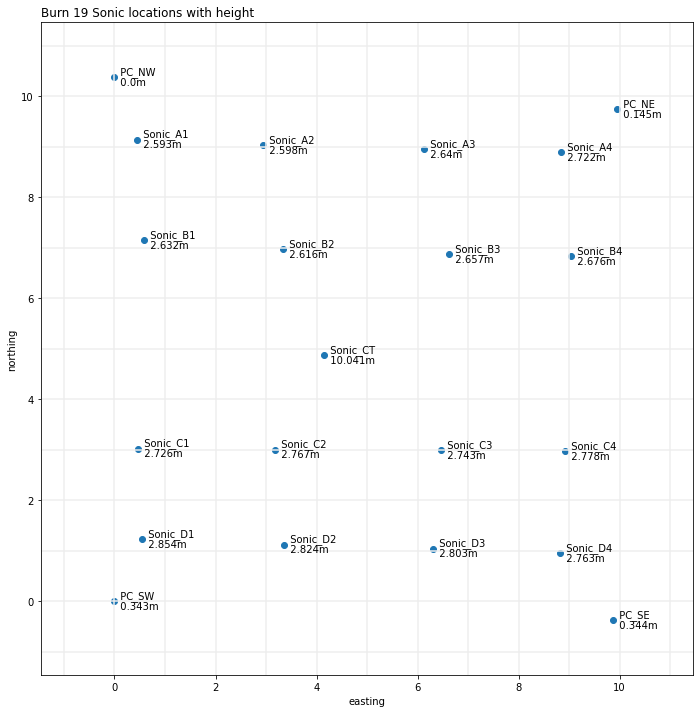

In [55]:
# set location headers - depending on dataset
loc_headers = ('X', 'Y', 'Z', 'LABEL')

# subset just the x, y, z locations and labels
item_types = ['Plot Corner', 'Sonic']
sonic_plot_locs = np.array(burn_locs.query(f'ITEM in {item_types}').loc[:, loc_headers])

# configure info for the axes
x_min_max = [sonic_plot_locs[:, 0].min(), sonic_plot_locs[:, 0].max()]
y_min_max = [sonic_plot_locs[:, 1].min(), sonic_plot_locs[:, 1].max()]
buffer = 0.1 * (max((x_min_max[1], y_min_max[1])) - min((x_min_max[0], y_min_max[0])))
min_max = [min((x_min_max[0], y_min_max[0])) - buffer, max((x_min_max[1], y_min_max[1])) + buffer]

# plot the locations
loc_fig, loc_axs = plt.subplots(figsize=(15, 12))
loc_axs.set_aspect('equal')
loc_axs.set_xlim(min_max); loc_axs.set_ylim(min_max)
for i in range(math.trunc(min_max[0]), math.trunc(min_max[1]) + 1):
    plt.axhline(y=i, color='#eeeeee')
    plt.axvline(x=i, color='#eeeeee')
loc_axs.scatter(sonic_plot_locs[:, 0], sonic_plot_locs[:, 1], marker='o')
for loc_set in sonic_plot_locs:
    loc_axs.text(loc_set[0], loc_set[1], f'  {loc_set[3]}', {'ha': 'left', 'va': 'bottom'})
    loc_axs.text(loc_set[0], loc_set[1], f'  {loc_set[2]}m', {'ha': 'left', 'va': 'top'})
loc_axs.set_ylabel('northing')
loc_axs.set_xlabel('easting')
loc_axs.set_title(f'Burn {burn_id} Sonic locations with height', loc='left')
plt.show()

## Select Sonic Sensors

In [15]:
sonic_sensor_ids = ['Control']
for loc_set in sonic_plot_locs:
    if loc_set[3].startswith('Sonic'):
        sonic_sensor_ids.append('_'.join(loc_set[3].split('_')[1:]))
print(f'Burn {burn_id} sonic sensor ids: {sonic_sensor_ids}')

Burn 19 sonic sensor ids: ['Control', 'A1', 'A2', 'A3', 'A4', 'B1', 'B2', 'B3', 'B4', 'C1', 'C2', 'C3', 'C4', 'CT', 'D1', 'D2', 'D3', 'D4']


In [16]:
sonic_sensors = []  # if all, leave list empty
exclude_sensors = []  # Add sensor identifiers to exclude

if not sonic_sensors:
    sonic_sensors = sonic_sensor_ids
    
for sensor_id in exclude_sensors:
    sonic_sensors.pop(sensor_id)
    
print(f'Selected sensors: {sonic_sensors}')

Selected sensors: ['Control', 'A1', 'A2', 'A3', 'A4', 'B1', 'B2', 'B3', 'B4', 'C1', 'C2', 'C3', 'C4', 'CT', 'D1', 'D2', 'D3', 'D4']


-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------


## Combine raw data
Read in the individual sensor files and build a xarray.Dataset

In [17]:
# Look at data column headers
dd_headers, data_dd = read_csv_to_dict(os.path.join(local_source_dir, 'data/Sonic_dd.csv'))

File header: ['Column_or_Row_Name', 'Unit', 'Definition', 'Column_or_Row_Long_Name', 'Data_Type']


In [18]:
# print dd info if needed
for dd in data_dd.values():
    display(f'{dd.get(dd_headers[0])} - Unit: {dd.get(dd_headers[1])} - Definition: {dd.get(dd_headers[2])}')

'TIMESTAMP - Unit: yyyy-MM-dd hh:mm:ss.0 - Definition: Local (EST) time adjusted for daylight savings. Note in Excel, set the specified format (yyyy-MM-dd hh:mm:ss.0) using the custom category to view the data correctly.'

'RECORD - Unit: None - Definition: None'

'U - Unit: m/s - Definition: Positive values of x (+) indicate wind from the east, negative values (-) indicate wind from the west. (Multiply U by -1 to convert positive U values to indicate wind from the west and negative U values indicating wind from the east).'

'V - Unit: m/s - Definition: Positive values of y (+) indicate wind from the north, negative values (-) indicate wind from the south. (Multiply V by -1 to convert positive V values to indicate wind from the south and negative U values indicating wind from the north).'

'W - Unit: m/s - Definition: Positive values of z (+) indicate upward wind direction, negative values (-) indicate downward wind direction.'

'T - Unit: deg C - Definition: calculated from speed of sound measurements in degrees Celsius (±2 deg C).'

'DIAG - Unit: None - Definition: Sonic diagnostic code (0 – valid, non-zero code – invalid measurement) as described in the manual.'

In [19]:
# Set the data location and get a list of the data files
burn_sonic_dir = os.path.join(local_source_dir, f'data/Burn{burn_id}_Sonic')
sensor_file_list = os.listdir(burn_sonic_dir)
sensor_file_list.sort()

# set the column names
wind_components = ['U', 'V', 'W']
error_code_header = 'DIAG'
loc_dim = 'loc'

# initiate a temporary dictionary to build the combined data
all_raw_data = {}
raw_uvw = []
loc_data = {}

for file_idx, sensor_file in enumerate(sensor_file_list):
    has_loc_info = False
    file_pieces = sensor_file.split('.')[0].split('_')
    sensor_id = file_pieces[-1] if len(file_pieces) == 3 else f'{file_pieces[-2]}_{file_pieces[-1]}'
    if sensor_id not in sonic_sensors:
        continue
           
    # read in the data file
    data = pd.read_csv(os.path.join(burn_sonic_dir, sensor_file))
    uvw = np.array(data.loc[:, wind_components[0]:wind_components[2]])
        
    # set up pandas output dataframe
    if file_idx == 0:
        sensor_id0 = sensor_id
        timeseries0 = data.loc[:, 'TIMESTAMP']
        all_raw_data['time'] = pd.to_datetime(timeseries0)
        
    timeseries = data.loc[:, 'TIMESTAMP']
    
    if file_idx > 0:
        if not timeseries.equals(timeseries0):
            print(f'Sensor {sensor_id} timeseries {timeseries.shape} did not match initial sensor {sensor_id0}: Skipping file {sensor_file}')
            print(data.loc[0:5, 'TIMESTAMP'])
            continue
    
    raw_uvw.append(uvw)
            
    for wind_component in wind_components:
        all_raw_data.setdefault(wind_component, []).append(data.loc[:, wind_component])
    
    all_raw_data.setdefault('sensor_id', []).append(sensor_id)
    all_raw_data.setdefault('error_code', []).append(data.loc[:, error_code_header])
    
    
    for x, y, z, label in sonic_plot_locs:
        if sensor_id in label:
            has_loc_info = True
            break
            
    if not has_loc_info:
        x, y, z = (-1, -1, 0)
        print(f'Sensor ID {sensor_id} has no location')
    
    loc_data.setdefault('easting', []).append(x)
    loc_data.setdefault('northing', []).append(y)
    loc_data.setdefault('z', []).append(z)
        
dataset = xr.Dataset({
    'u': ([loc_dim, 'time'], all_raw_data[wind_components[0]]),
    'v': ([loc_dim, 'time'], all_raw_data[wind_components[1]]),
    'w': ([loc_dim, 'time'], all_raw_data[wind_components[2]]),
    'error_code': ([loc_dim, 'time'], all_raw_data['error_code'])  
},
coords={
    'id': ([loc_dim], all_raw_data['sensor_id']),
    'easting': ([loc_dim], loc_data['easting']),
    'northing': ([loc_dim], loc_data['northing']),
    'z': ([loc_dim], loc_data['z']),
    'time': all_raw_data['time']
})


del all_raw_data, data, uvw
display(dataset)

Sensor ID Control has no location


<xarray.Dataset>
Dimensions:     (loc: 18, time: 49951)
Coordinates:
    id          (loc) <U7 'A1' 'A2' 'A3' 'A4' 'B1' ... 'D1' 'D2' 'D3' 'D4'
    easting     (loc) float64 0.4445 2.931 6.124 8.847 ... 3.359 6.306 8.824
    northing    (loc) float64 9.139 9.025 8.95 8.894 ... 1.227 1.121 1.044 0.95
    z           (loc) float64 2.593 2.598 2.64 2.722 ... 2.854 2.824 2.803 2.763
  * time        (time) datetime64[ns] 2018-09-22T16:32:16 ... 2018-09-22T17:5...
Dimensions without coordinates: loc
Data variables:
    u           (loc, time) float64 -0.46 -0.34 -0.36 ... -0.15 -0.19 -0.19
    v           (loc, time) float64 0.67 0.62 0.66 0.68 ... 0.0 0.0 -0.03 -0.03
    w           (loc, time) float64 -0.31 -0.34 -0.22 -0.09 ... 0.03 0.0 0.0 0.0
    error_code  (loc, time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

## Calculate wind speed and direction

In [20]:
calc_data = {}
calc_store = {'speed': calc_speed, 
              'uv_speed': calc_horiz_speed, 'uv_bearing': calc_horiz_bearing, 
              'w_speed': calc_vert_speed, 'w_dir': calc_vert_direction}

for uvw in raw_uvw:
    for cname, cfunc in calc_store.items():
        calc_data.setdefault(cname, []).append(np.apply_along_axis(cfunc, 1, uvw))

print('done')
del raw_uvw, uvw

done


In [21]:
for var, data in calc_data.items():
    dataset = dataset.update({var: ([loc_dim, 'time'], data)})

del calc_data, var, data
display(dataset)

<xarray.Dataset>
Dimensions:     (loc: 18, time: 49951)
Coordinates:
    id          (loc) <U7 'A1' 'A2' 'A3' 'A4' 'B1' ... 'D1' 'D2' 'D3' 'D4'
    easting     (loc) float64 0.4445 2.931 6.124 8.847 ... 3.359 6.306 8.824
    northing    (loc) float64 9.139 9.025 8.95 8.894 ... 1.227 1.121 1.044 0.95
    z           (loc) float64 2.593 2.598 2.64 2.722 ... 2.854 2.824 2.803 2.763
  * time        (time) datetime64[ns] 2018-09-22T16:32:16 ... 2018-09-22T17:5...
Dimensions without coordinates: loc
Data variables:
    u           (loc, time) float64 -0.46 -0.34 -0.36 ... -0.15 -0.19 -0.19
    v           (loc, time) float64 0.67 0.62 0.66 0.68 ... 0.0 0.0 -0.03 -0.03
    w           (loc, time) float64 -0.31 -0.34 -0.22 -0.09 ... 0.03 0.0 0.0 0.0
    error_code  (loc, time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    speed       (loc, time) float64 0.8698 0.7846 0.7833 ... 0.15 0.1924 0.1924
    uv_speed    (loc, time) float64 0.8127 0.7071 0.7518 ... 0.15 0.1924 0.1924
    uv_bearing  (loc, time) float64 325.5 331.3 331.4 ... 270.0 261.0 261.0
    w_speed     (loc, time) float64 0.31 0.34 0.22 0.09 ... 0.03 0.0 0.0 0.0
    w_dir       (loc, time) int64 -1 -1 -1 -1 1 -1 -1 -1 -1 ... 1 1 1 1 1 0 0 0

-------------------------------------------------------------------------------------

## Generatate statistics

Calc min / max windspeed with their timestamps, and number of missing values and errors.

In [22]:
# choose one of the variable for which to display status below
display(dataset.data_vars)

var = 'speed'
display(gen_stats(dataset, var, 'time', 3))

Data variables:
    u           (loc, time) float64 -0.46 -0.34 -0.36 ... -0.15 -0.19 -0.19
    v           (loc, time) float64 0.67 0.62 0.66 0.68 ... 0.0 0.0 -0.03 -0.03
    w           (loc, time) float64 -0.31 -0.34 -0.22 -0.09 ... 0.03 0.0 0.0 0.0
    error_code  (loc, time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    speed       (loc, time) float64 0.8698 0.7846 0.7833 ... 0.15 0.1924 0.1924
    uv_speed    (loc, time) float64 0.8127 0.7071 0.7518 ... 0.15 0.1924 0.1924
    uv_bearing  (loc, time) float64 325.5 331.3 331.4 ... 270.0 261.0 261.0
    w_speed     (loc, time) float64 0.31 0.34 0.22 0.09 ... 0.03 0.0 0.0 0.0
    w_dir       (loc, time) int64 -1 -1 -1 -1 1 -1 -1 -1 -1 ... 1 1 1 1 1 0 0 0

,Sensor,max_speed,time_max_speed,speed_count_over_3,min_speed,time_min_speed,speed_nan,speed_errors
loc,,,,,,,,
0,A1,2.835648,2018-09-22 16:45:22.100,0,0.000000,2018-09-22 16:38:46.600,0,0
1,A2,139.755523,2018-09-22 16:57:41.900,12,0.000000,2018-09-22 16:38:23.400,0,1
2,A3,141.505626,2018-09-22 16:57:46.600,33,0.000000,2018-09-22 16:43:23.100,0,1
3,A4,3.434894,2018-09-22 16:33:19.800,10,0.000000,2018-09-22 16:40:10.500,0,0
4,B1,2.794083,2018-09-22 16:33:08.800,0,0.000000,2018-09-22 16:34:32.400,0,0
5,B2,148.494480,2018-09-22 16:59:06.900,52,0.000000,2018-09-22 16:54:00.700,0,69
6,B3,3.800053,2018-09-22 17:24:25.200,34,0.000000,2018-09-22 16:43:18.200,0,0
7,B4,3.322409,2018-09-22 17:53:58.100,8,0.000000,2018-09-22 16:40:10.000,0,0
8,C1,3.481638,2018-09-22 16:33:09.800,2,0.000000,2018-09-22 16:32:40.000,0,0


-------------------------------------------------------------------------------------

## Aggregate to minute resolution

Aggregate

In [23]:
data_minute = dataset.groupby('time.minute').mean()

display(data_minute.data_vars)

Data variables:
    u           (minute, loc) float64 -0.5007 -0.3641 -0.4408 ... 0.5885 0.5128
    v           (minute, loc) float64 0.3842 0.4254 0.3269 ... 0.2109 0.1963
    w           (minute, loc) float64 -0.2015 -0.09953 ... -0.05657 -0.0811
    error_code  (minute, loc) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    speed       (minute, loc) float64 0.7398 0.6371 0.6389 ... 0.6957 0.6532
    uv_speed    (minute, loc) float64 0.6991 0.592 0.5893 ... 0.6772 0.6362
    uv_bearing  (minute, loc) float64 285.5 313.6 303.6 ... 82.45 93.59 117.8
    w_speed     (minute, loc) float64 0.2082 0.1881 0.203 ... 0.1216 0.1212
    w_dir       (minute, loc) float64 -0.8467 -0.57 -0.685 ... -0.415 -0.6417

In [24]:
var = 'speed'
display(gen_stats(data_minute, var, 'minute', 1))

,Sensor,max_speed,time_max_speed,speed_count_over_1,min_speed,time_min_speed,speed_nan,speed_errors
loc,,,,,,,,
0,A1,0.790747,15.0,0,0.245669,28.0,0,0
1,A2,0.881259,27.0,0,0.284520,43.0,0,1
2,A3,0.929484,24.0,0,0.280950,53.0,0,1
3,A4,0.847725,24.0,0,0.212705,13.0,0,0
4,B1,0.755423,39.0,0,0.239277,7.0,0,0
5,B2,2.961858,58.0,6,0.250596,54.0,0,12
6,B3,0.966205,24.0,0,0.281928,54.0,0,0
7,B4,0.972265,24.0,0,0.249680,43.0,0,0
8,C1,0.860022,24.0,0,0.290221,36.0,0,0


-------------------------------------------------------------------------------------

## Visualizations

### Select dataset and sensors

In [31]:
# dataset and dimension corresponding to the dataset
ds = dataset; dim = 'time'
display(ds.id.values)

array(['A1', 'A2', 'A3', 'A4', 'B1', 'B2', 'B3', 'B4', 'C1', 'C2', 'C3',
       'C4', 'CT', 'Control', 'D1', 'D2', 'D3', 'D4'], dtype='<U7')

In [32]:
# set sensors, use empty list for all
sensors = ['A1', 'A2', 'A3', 'A4']

# automatically get the indices and data
sensor_indices = get_id_indices(ds, sensors)
display(sensor_indices)

[0, 1, 2, 3]

### Timeseries of specified variable for specified sensors

In [33]:
# Show variable options
display(ds.data_vars)

Data variables:
    u           (loc, time) float64 -0.46 -0.34 -0.36 ... -0.15 -0.19 -0.19
    v           (loc, time) float64 0.67 0.62 0.66 0.68 ... 0.0 0.0 -0.03 -0.03
    w           (loc, time) float64 -0.31 -0.34 -0.22 -0.09 ... 0.03 0.0 0.0 0.0
    error_code  (loc, time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    speed       (loc, time) float64 0.8698 0.7846 0.7833 ... 0.15 0.1924 0.1924
    uv_speed    (loc, time) float64 0.8127 0.7071 0.7518 ... 0.15 0.1924 0.1924
    uv_bearing  (loc, time) float64 325.5 331.3 331.4 ... 270.0 261.0 261.0
    w_speed     (loc, time) float64 0.31 0.34 0.22 0.09 ... 0.03 0.0 0.0 0.0
    w_dir       (loc, time) int64 -1 -1 -1 -1 1 -1 -1 -1 -1 ... 1 1 1 1 1 0 0 0

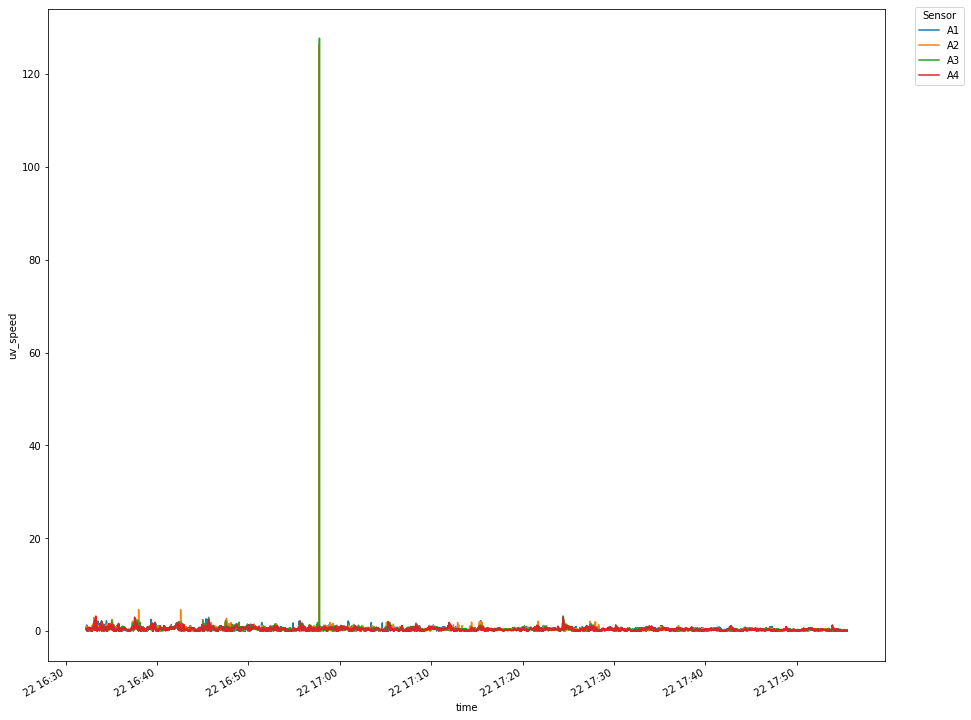

In [35]:
# select variable
var = 'uv_speed'

# slice data
var_slice = ds[var].isel(dict(loc=sensor_indices))

# generate linear timeseries figure
fig, axs = plt.subplots(figsize=(15, 12))
f = xplt.line(var_slice, ax=axs, x=dim, add_legend=False)
axs.legend(handles=f, labels=list(var_slice.id.values), title='Sensor', loc='upper right', bbox_to_anchor=(1.1, 1.01))

line_colors = {}
for line_id, f_line in zip(var_slice.id.values, f):
    line_colors[line_id] = f_line.get_c()

### Timeseries of bearing

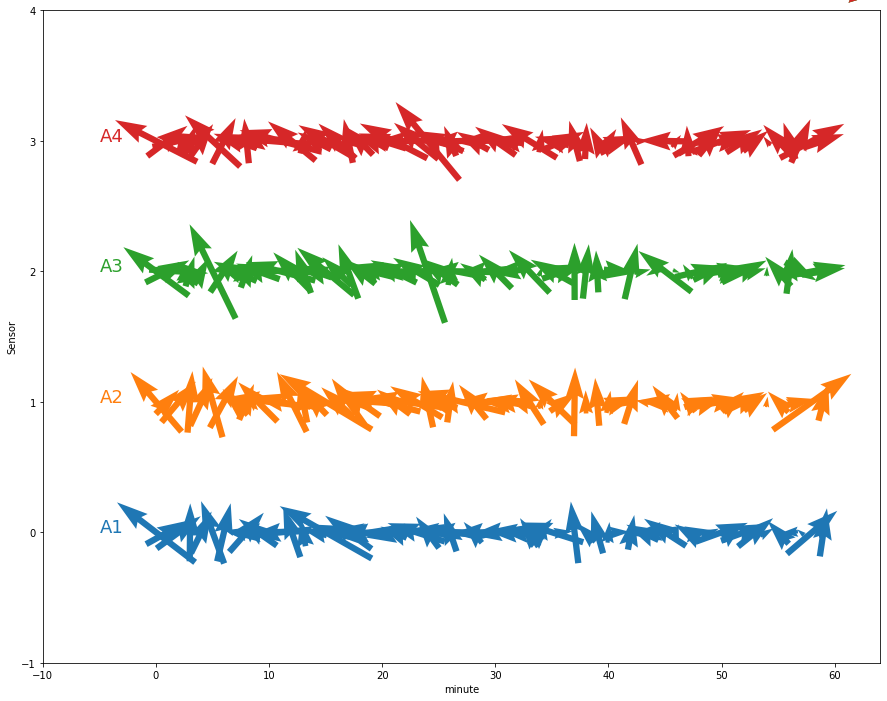

In [29]:
# slice data
var_slice = ds[var].isel(dict(loc=sensor_indices))
count = len(var_slice.id.values)
u_slice = ds['u'].isel(dict(loc=sensor_indices))
v_slice = ds['v'].isel(dict(loc=sensor_indices))

# set up figure configuration
ylim = [var_slice.min().values, var_slice.max().values]
axs_buffer = [5, 1]

# generate linear timeseries figure
fig, axs = plt.subplots(figsize=(15, 12))
axs.set_xlim([var_slice.minute[0] - 2 * axs_buffer[0], var_slice.minute[-1] + axs_buffer[0]])
axs.set_ylim([-axs_buffer[1], count + axs_buffer[1] - 1])
axs.set_ylabel('Sensor'); axs.set_xlabel(dim)

for idx in range(0, count):
    sid = list(var_slice.id.values)[idx]
    scol = line_colors[sid]
    Q = axs.quiver(var_slice.minute, np.full(var_slice[dim].shape[0], idx), u_slice.isel(loc=idx).values, v_slice.isel(loc=idx).values, 
                   pivot='mid', units='width', color=scol)
    qk = axs.quiverkey(Q, 0.9, 0.9, 1, r'$1 \frac{m}{s}$', labelpos='E', coordinates='figure')
    axs.text(var_slice.minute[0] - axs_buffer[0], idx, sid, color=scol, fontsize=18)


### Individual plots of speed + direction for single specified sensor

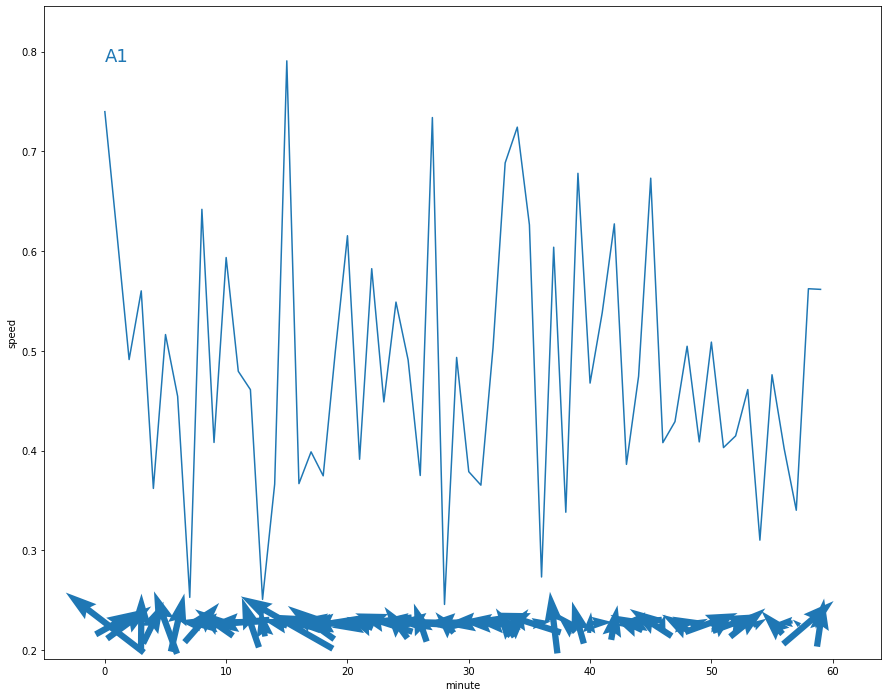

In [30]:
sid = 'A1'
sidx = get_id_indices(ds, [sid])[0]

# select variable
var = 'speed'

# slice data
var_slice = ds[var].isel(dict(loc=sidx))
u_slice = ds['u'].isel(dict(loc=sidx))
v_slice = ds['v'].isel(dict(loc=sidx))
try:
    scol = line_colors[sid]
except:
    scol = 'black'

# set up figure configuration
ylim = [var_slice.min().values, var_slice.max().values]
axs_buffer = [5, 0.1]

# generate linear timeseries figure
fig, axs = plt.subplots(figsize=(15, 12))
axs.set_xlim([var_slice[dim][0] - axs_buffer[0], var_slice[dim][-1] + axs_buffer[0]])
axs.set_ylim([ylim[0] - axs_buffer[1] * (ylim[1]-ylim[0]), ylim[1] + axs_buffer[1] * (ylim[1]-ylim[0])])
axs.set_ylabel(var); axs.set_xlabel(dim)

axs.plot(var_slice[dim], var_slice.values)
Q = axs.quiver(var_slice[dim], np.full(var_slice[dim].shape[0], ylim[0] - axs_buffer[1]/3 * (ylim[1]-ylim[0])), u_slice.values, v_slice.values, 
               pivot='mid', units='width', color=scol)
qk = axs.quiverkey(Q, 0.9, 0.9, 1, r'$1 \frac{m}{s}$', labelpos='E', coordinates='figure')
t = axs.text(var_slice.minute[0], ylim[1], sid, color=scol, fontsize=18)

### Step thru time for speed and direction overlaid on locations